## Import Libraries

In [1]:
import cv2 # OpenCV library
import numpy as np # Numpy library for scientific computing
import matplotlib.pyplot as plt # Matplotlib library for plotting

MAZE_FILE_NAME = "../../Maze.png"
ROBOT_FILE_NAME = "../../Robot.png"
MAP_FILE_NAME = "../../MapFound.txt"

## 3.1 Read Maze.png and Display in RGB 

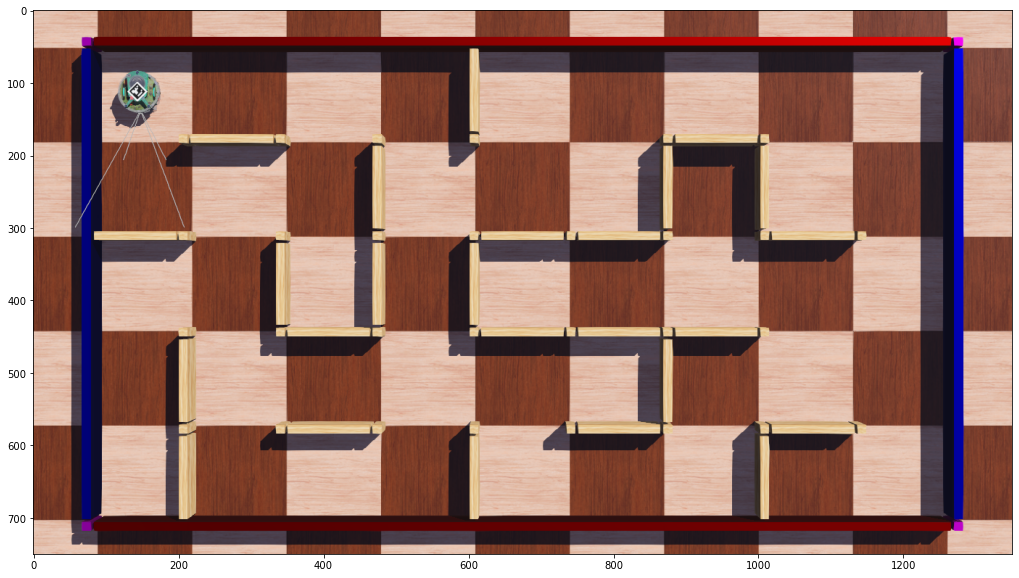

In [2]:
def imgReadAndDisplay(path):
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.figure(figsize = (18, 10))
    plt.imshow(img_rgb)
    plt.show
    return [img,img_rgb]

[maze,maze_rgb] = imgReadAndDisplay(MAZE_FILE_NAME)

## 3.2 Find Four Cornerstones of The Maze

In [3]:
# HSV min/max values
hMin = 139
sMin = 88
vMin = 95
hMax = 154
sMax = 255
vMax = 255 

kernel = np.ones((3,3), np.uint8)

# Set minimum and maximum of HSV values
lower = np.array([hMin, sMin, vMin])
upper = np.array([hMax, sMax, vMax])

#create list for centroid
centroidList = []

#function to get centrioid
def getCentroids(contours,centroidList):
    for i, cnt in enumerate(contours):
        M = cv2.moments(cnt)
        #calculate the centroid of each cornerstones for maze.png
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroidList.append(tuple([cX,cY]))

#function to find four cornerstones
def findCornerstone(img,lower,upper):
    
    # Convert to HSV format and color threshold
    maze_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(maze_hsv, lower, upper)
    result = cv2.bitwise_and(img, img, mask=mask)
    
    # Convert grayscale image to color image for displaying simultaneous
    mask_3_channel = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    
    #morphological operations
    mask_3_channel = cv2.morphologyEx(mask_3_channel, cv2.MORPH_OPEN, kernel)
    mask_3_channel = cv2.morphologyEx(mask_3_channel, cv2.MORPH_CLOSE, kernel)
    
    #find contours
    edges = cv2.Canny(mask_3_channel, threshold1 = 50, threshold2 = 100, apertureSize = 3)
    img2, contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    maze_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #to close open contours
    for i, cnt in enumerate(contours):
        contours[i] = cv2.convexHull(contours[i])
    
    #find the centroids
    getCentroids(contours,centroidList)
    
    #draw circle on the cornerstone
    i=0
    for i in range(4): 
        maze_rgb = cv2.circle(maze_rgb,(centroidList[i][0],centroidList[i][1]),20,(0,255,255),2)
    
    plt.figure(figsize = (18, 10))
    plt.imshow(maze_rgb)
    plt.show() 
    
    return contours

contours = findCornerstone(maze,lower,upper)

ValueError: not enough values to unpack (expected 3, got 2)

## 3.3 Prespective transform the maze

In [4]:
def transformAndPrint(centroidList,img):
    bottomRight = tuple()
    bottomLeft = tuple()
    topRight = tuple()
    topLeft = tuple()
    i=0
    #sort the centroids so that the points match
    for i in range(4):
        if centroidList[i][0] >= 1012.5 and centroidList[i][0] <= 1350 and centroidList[i][1] >= 375 and centroidList[i][1] <= 750:
            bottomRight = centroidList[i]
        elif centroidList[i][0] >= 0 and centroidList[i][0] <= 337.5 and centroidList[i][1] >= 375 and centroidList[i][1] <= 750:
            bottomLeft = centroidList[i]
        elif centroidList[i][0] >= 1012.5 and centroidList[i][0] <= 1350 and centroidList[i][1] >= 0 and centroidList[i][1] <= 375:
            topRight = centroidList[i]
        elif centroidList[i][0] >= 0 and centroidList[i][0] <= 337.5 and centroidList[i][1] >= 0 and centroidList[i][1] <= 375: 
            topLeft = centroidList[i]
    
    pts1 = np.float32([[bottomRight],[bottomLeft],[topRight],[topLeft]]) # four points on the first image
    pts2 = np.float32([[900,500],[0,500],[900,0],[0,0]]) # four points on the second image
    
    H = cv2.getPerspectiveTransform(pts1,pts2) # homography matrix
    transformedImg = cv2.warpPerspective(img, H, (900,500)) 
    
    plt.figure(figsize = (18, 10))
    plt.imshow(transformedImg)
    plt.show() 
    
    return transformedImg,bottomRight,bottomLeft,topRight,topLeft


In [5]:
getCentroids(contours,centroidList)
transformedMaze,bottomRight,bottomLeft,topRight,topLeft = transformAndPrint(centroidList,maze_rgb)

NameError: name 'contours' is not defined

## 3.4 Detecting All Internal Walls

In [6]:
#HSV min/max values
hMin = 17
sMin = 0
vMin = 215
hMax = 20
sMax = 255
vMax = 255 

#different size kernels
kernel = np.ones((3,3), np.uint8)
kernel1 = np.ones((5,5), np.uint8)
kernel2 = np.ones((9,9), np.uint8)

# Set minimum and maximum HSV values to display
lower = np.array([hMin, sMin, vMin])
upper = np.array([hMax, sMax, vMax])

#function to find four cornerstones
def findWalls(img,lower,upper):
    
    # Convert to HSV format and color threshold
    maze_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(maze_hsv, lower, upper)
    result = cv2.bitwise_and(img, img, mask=mask)
    
    #morphological operations
    mask_3_channel = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel1)
    mask_3_channel = cv2.morphologyEx(mask_3_channel, cv2.MORPH_DILATE, kernel2)
    mask_3_channel = cv2.morphologyEx(mask_3_channel, cv2.MORPH_ERODE, kernel2)
    mask_3_channel = cv2.morphologyEx(mask_3_channel, cv2.MORPH_ERODE, (2,2))
    mask_3_channel = cv2.morphologyEx(mask_3_channel, cv2.MORPH_OPEN, kernel)
    
    #make walls cyan
    indices = np.where(mask_3_channel ==255)
    img[indices[0], indices[1], :] = [0, 255, 255]
    
    plt.figure(figsize = (18, 10))
    plt.imshow(img,cmap='gray')
    plt.show() 
    
    return img, mask_3_channel

transfordMazeWithWalls, wallMask = findWalls(transformedMaze,lower,upper)

NameError: name 'transformedMaze' is not defined

## 3.5 Detect the location and heading of the robot

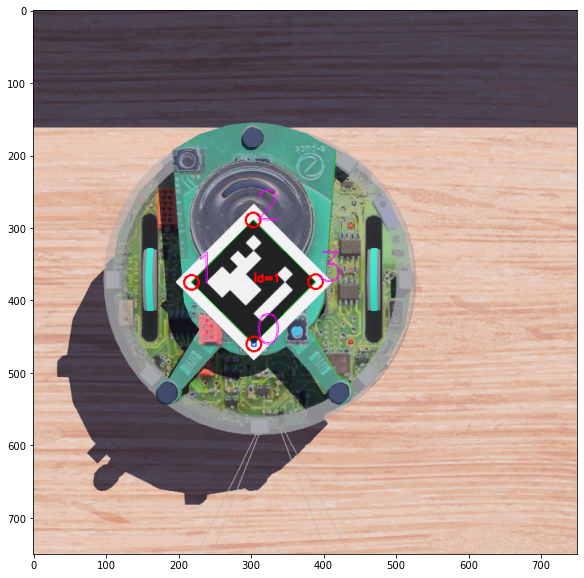

In [7]:
#read the robot.png file
robotImg = cv2.imread(ROBOT_FILE_NAME)
#convert colour from BGR to RGB
robotImg = cv2.cvtColor(robotImg, cv2.COLOR_BGR2RGB) 

def aruco(img):  

    dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)
    parameters = cv2.aruco.DetectorParameters_create()
    markerCorners, markerIds, rejectedCandidates = cv2.aruco.detectMarkers(img, dictionary, parameters=parameters)

    img_rgb = cv2.aruco.drawDetectedMarkers(img, markerCorners, markerIds)
    colour = (255,0,0)
    radius = 10
    thickness = 2
    i = 0
    font =cv2.FONT_HERSHEY_DUPLEX
    
    #check the order of each corner of the aruco marker
    for i in range(4):
        img_rgb = cv2.circle(img_rgb, (markerCorners[0][0][i][0],markerCorners[0][0][i][1]),radius,colour,thickness)
        cv2.putText(img_rgb,str(i),(markerCorners[0][0][i][0],markerCorners[0][0][i][1]),font,2, (255,0,255))
    
    #find the angle between the 0th and 2nd corner
    differenceX = markerCorners[0][0][2][0]-markerCorners[0][0][0][0]
    differenceY = markerCorners[0][0][2][1]-markerCorners[0][0][0][1]
    angle = np.arctan2(differenceY,differenceX)* 180 / np.pi
    direction = ''
    
    #north
    if angle >= 45.0 and angle <= 135.0:
        direction = '^'
    #west
    elif angle <= 45.0 and angle >=0 or angle >= -45.0 and angle <= 0:
        direction = '<'
    #south
    elif angle <= -45.0 and angle >= -135.0:
        direction = 'v'
    #east
    elif angle <= -135.0 and angle >= -180.0 or angle >= 135.0 and angle <= 180.0:
        direction = '>'
      
    plt.figure(figsize = (18, 10))
    plt.imshow(img_rgb)
    plt.show() 
    
    return direction
    
direction = aruco(robotImg)

In [8]:
# HSV min/max values
hMin = 104
sMin = 0
vMin = 181
hMax = 120
sMax = 100
vMax = 255

# Set minimum and maximum HSV values to display
lower = np.array([hMin, sMin, vMin])
upper = np.array([hMax, sMax, vMax])

def findHeading(img,lower,upper,direction):
    
    #different size of kernel
    kernel = np.ones((3,3), np.uint8)
    kernel1 = np.ones((5,5), np.uint8)
    kernel3 = np.ones((6,6), np.uint8)
    
    # Convert to HSV format and color threshold
    maze_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(maze_hsv, lower, upper)
    result = cv2.bitwise_and(img, img, mask=mask)
    
    #morphological operations
    mask_3_channel = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel3)    
    mask_3_channel = cv2.morphologyEx(mask_3_channel, cv2.MORPH_OPEN, kernel)
    mask_3_channel = cv2.morphologyEx(mask_3_channel, cv2.MORPH_DILATE, kernel1)
    
    #find the robot
    edges = cv2.Canny(mask_3_channel, threshold1 = 50, threshold2 = 100, apertureSize = 3)
    img2, contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    #get the centroid of the robot
    centroid = []
    getCentroids(contours,centroid)
    
    #draw circle
    img = cv2.circle(img,(centroid[0][0],centroid[0][1]),20,(255,0,255),2)
    
    #put '>,<,v,^' into the middle of the circle
    FONT = cv2.FONT_HERSHEY_DUPLEX
    TEXT_SCALE = 1.0
    TEXT_THICKNESS = 2 
    text_size, _ = cv2.getTextSize(direction, FONT, TEXT_SCALE, TEXT_THICKNESS)
    text_origin = (int(centroid[0][0] - text_size[0] / 2), int(centroid[0][1] + text_size[1] / 2))
    cv2.putText(img, direction, text_origin, FONT, TEXT_SCALE, (255,0,255), TEXT_THICKNESS, cv2.LINE_AA)
    
    #display image
    plt.figure(figsize = (18, 10))
    plt.imshow(img,cmap='gray')
    plt.show() 
    
    #get the robot position
    robotPosition = (centroid[0][0],centroid[0][1])
    
    return robotPosition, direction

pos,heading= findHeading(transfordMazeWithWalls,lower,upper,direction)

NameError: name 'transfordMazeWithWalls' is not defined

## Generate a map and write it to a text file

In [9]:
def generateMap(img,position,heading):
    horizontalWalls = []
    verticalWalls = []
    i=0
    j=0
    y=0
    
    #find horizontal wall
    for i in range(6):
        horizontalWalls.append([])
        x=50
        for j in range(9):
            if i == 0 or i == 5:
                horizontalWalls[i].append(" ---")
            else:
                #add tolerence +- 1 pixel on the y axis
                if img[y,x] == 255 or img[y+1,x] == 255 or img[y-1,x] == 255:
                    horizontalWalls[i].append(" ---")
                else:
                    horizontalWalls[i].append("    ")
                x=x+100
        y=y+100

    i=0
    j=0
    y=50
    #find vertical walls
    for i in range(5):
        verticalWalls.append([])
        x=0
        for j in range(10):
            if j == 0:
                verticalWalls[i].append("|   ")
            elif j == 9:
                verticalWalls[i].append("|")
            elif img[y,x] == 255 or img[y,x+1] == 255 or img[y,x-1] == 255:
                verticalWalls[i].append("|   ")
            else:
                verticalWalls[i].append("    ")
            x=x+100            
        y=y+100
        
    # robotX in x axis, robotY in y axis
    #get robot position in [i][j]
    robotX = int(np.floor(position[0]/100))
    robotY = int(np.floor(position[1]/100))
    
    #insert robot position
    tmp = list(verticalWalls[robotY][robotX])
    tmp[2] = heading
    tmp = "".join(tmp)
    verticalWalls[robotY][robotX] = tmp
        
    #combine map
    map = ""
    i=0
    j=0
    k=0
    a=0
    b=0
    for i in range(11):
        if i%2 == 0:
            for j in range(9):
                map += horizontalWalls[a][j]
            a=a+1
        else:
            for k in range(10):
                map += verticalWalls[b][k]
            b=b+1
        map += "\n"
    
    print(map)
    return map

#write into MapFound.txt
def writeToFile(map):
    file = open(MAP_FILE_NAME, "w")
    file.write(map)
    file.close()

map = generateMap(wallMask,pos,heading)
writeToFile(map)

NameError: name 'wallMask' is not defined